GitHub link: [ridvikpal/FruitSalad](https://github.com/ridvikpal/FruitSalad)

# Library imports & prerequisites

Import required libraries.

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms, datasets
import torch.optim as optim
import torch.nn as nn
import numpy as np
import time
import matplotlib.pyplot as plt
from google.colab import drive

Mount google drive.

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Setup our results folder in google drive, where we will store our saved model training checkpoints and csv results data.

In [ ]:
results_folder_path = ("/content/gdrive/MyDrive/Colab Notebooks"
                        "/APS360/Project/Results")

Determine which device we can use for training. In Google Collab, you can select to use the Nvidia T4 for the runtime.

In [ ]:
def determine_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("CUDA is available. Using GPU for training.")
    else:
        device = torch.device("cpu")
        print("CUDA is not available. Using CPU for training.")

    return device

device = determine_device()

CUDA is not available. Using CPU for training.


# Models

## Primary models

The primary model uses a combination of a CNN and a fully connected classification network. I chose to make 3 variations of the primary model, to test different architecture decisions.

The first variation of the primary model contains:

- 3 convolutional layers, with channels 3 -> 16 -> 32 -> 64, and kernel sizes 3x3 with 1 unit of padding.
- 2 classification layers with features 32 -> 5.
- ReLU activation functions in between all layers.

In [ ]:
class PrimaryModel1(nn.Module):
    def __init__(self):
        super(PrimaryModel1, self).__init__()

        self.name = "primary_model_1"
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 32)
        self.fc2 = nn.Linear(32, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

The second variation of the primary model contains:

- 2 convolutional layers, with channels 3 -> 24 -> 48, kernel sizes 3x3 with 1 unit of padding and 2 units per stride.
- 2 classification layers with features 32 -> 5.
- ReLU activation functions in between all layers.

In [ ]:
class PrimaryModel2(nn.Module):
    def __init__(self):
        super(PrimaryModel2, self).__init__()

        self.name = "primary_model_2"
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 24, 3, padding=1, stride=2)
        self.conv2 = nn.Conv2d(24, 48, 3, padding=1, stride=2)
        self.fc1 = nn.Linear(48 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 48 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

The third variation of the primary model contains:

- 2 convolutional layers, with channels 3 -> 32 -> 64 -> 128, kernel sizes 3x3 and with 1 unit of padding.
- 3 classification layers with features 32 -> 16 -> 5.
- ReLU activation functions in between all layers.

In [ ]:
class PrimaryModel3(nn.Module):
    def __init__(self):
        super(PrimaryModel3, self).__init__()

        self.name = "primary_model_3"
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Baseline model

The baseline model is a basic fully connected neural network, and contains:

- 3 fully connected classification layers, with features 64 -> 32 -> 5.
- ReLU activation functions in between layers.

In [ ]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()

        self.name = "baseline_model"
        self.fc1 = nn.Linear(3 * 128 * 128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 5)

    def forward(self, x):
        x = x.view(-1, 3 * 128 * 128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Helper functions

A variety of helper functions were created to assist with training, as found below.

## Data loading and cleaning

In [ ]:
def get_data_loader(folder_path, batch_size):
    transform = transforms.Compose(
        [
            transforms.Resize(128), # resize the shortest side to 128
            transforms.CenterCrop(128), # crop to ensure the image is 128x128
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    print(f"Retrieving dataset from {folder_path}...")
    dataset = datasets.ImageFolder(f"{folder_path}", transform=transform)
    loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, num_workers=1, shuffle=True
    )
    print("Done retrieving dataset.")

    return loader

## Visualizing and plotting

In [ ]:
def plot_training_vs_validation_curve(path):
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))

    plt.title("Training vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def plot_training_curve(path):
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))

    plt.title("Training Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def get_model_name(name, batch_size, learning_rate, epoch, folder=""):
    path = (f"{folder}/model_{name}_bs{batch_size}_lr{learning_rate}"
            f"_epoch{epoch}")
    return path

## Training

In [ ]:
def evaluate(net, data_loader, criterion, device):
    total_loss = 0.0
    total_err = 0.0
    total_samples = 0

    # move the model to the correct device
    net.to(device)

    net.eval() # Set model to evaluation mode for optimization
    with torch.no_grad(): # Disable gradient calculation for optimization
        for i, data in enumerate(data_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # Multi-class error computation
            _, predicted = torch.max(outputs, 1)  # Get index of highest logit
            total_err += (predicted != labels).sum().item()
            total_loss += loss.item()
            total_samples += labels.size(0)

    err = float(total_err) / total_samples
    loss = float(total_loss) / (i + 1)
    return err, loss

def train_net(net, train_loader, device, val_loader=None, batch_size=64,
              learning_rate=0.01, num_epochs=30, results_folder=""):
    torch.manual_seed(1000)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)

    # only init validation error/loss variables if a val_loader is provided
    if (val_loader is not None):
        val_err = np.zeros(num_epochs)
        val_loss = np.zeros(num_epochs)

    # move the model to the correct device
    net.to(device)

    print("Beginning Training...")
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_samples = 0

        net.train() # Set model to training mode
        for i, data in enumerate(train_loader, 0):
            # Get the inputs, and move them to the right hardware (device)
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate error and store it for multi class classification
            _, predicted = torch.max(outputs, 1)
            total_train_err += (predicted != labels).sum().item()

            # Store loss
            total_train_loss += loss.item()
            total_samples += len(labels)

        train_err[epoch] = float(total_train_err) / total_samples
        train_loss[epoch] = float(total_train_loss) / (i+1)

        # Only calculate valdation error/loss if a val_loader is provided
        if (val_loader is not None):
            val_err[epoch], val_loss[epoch] = evaluate(net, val_loader,
                                                       criterion, device)
            print(
                f"Epoch: {epoch + 1} "
                f"Train err: {train_err[epoch]}, "
                f"Train loss: {train_loss[epoch]} "
                f"| Validation err: {val_err[epoch]}, "
                f"Validation loss: {val_loss[epoch]}"
            )
        else:
            print(
                f"Epoch: {epoch + 1} "
                f"Train err: {train_err[epoch]}, "
                f"Train loss: {train_loss[epoch]}"
            )

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch,
                                    results_folder)
        torch.save(net.state_dict(), model_path)

    print('Ending Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # Write the train loss/err into CSV file for plotting later
    np.savetxt(f"{model_path}_train_err.csv", train_err)
    np.savetxt(f"{model_path}_train_loss.csv", train_loss)

    # Only save the validation error/loss if a val_loader is provided
    if (val_loader is not None):
        np.savetxt(f"{model_path}_val_err.csv", val_err)
        np.savetxt(f"{model_path}_val_loss.csv", val_loss)

    # at the very end, empty the cuda cache if cuda is used
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Training & Validating

## Overfit testing

First, we test if our 3 primary models and baseline models can overfit to a small dataset. I created a subset of the actual training dataset, containing 5 images per fruit type (class) for overfitting testing.

In [ ]:
overfit_loader = get_data_loader("/content/gdrive/MyDrive/Colab Notebooks/APS360/Project/Overfit", 25)

Retrieving dataset from /content/gdrive/MyDrive/Colab Notebooks/APS360/Project/Overfit...
Done retrieving dataset.


Overfitting `PrimaryModel1()`:

Beginning Training...
Epoch: 1 Train err: 0.8, Train loss: 1.6141424179077148
Epoch: 2 Train err: 0.8, Train loss: 1.6126285791397095
Epoch: 3 Train err: 0.8, Train loss: 1.610030174255371
Epoch: 4 Train err: 0.8, Train loss: 1.6073119640350342
Epoch: 5 Train err: 0.8, Train loss: 1.6044328212738037
Epoch: 6 Train err: 0.8, Train loss: 1.6007577180862427
Epoch: 7 Train err: 0.76, Train loss: 1.5965138673782349
Epoch: 8 Train err: 0.68, Train loss: 1.5920028686523438
Epoch: 9 Train err: 0.56, Train loss: 1.587117314338684
Epoch: 10 Train err: 0.52, Train loss: 1.581374168395996
Epoch: 11 Train err: 0.4, Train loss: 1.5748569965362549
Epoch: 12 Train err: 0.32, Train loss: 1.5674835443496704
Epoch: 13 Train err: 0.28, Train loss: 1.5590949058532715
Epoch: 14 Train err: 0.32, Train loss: 1.5496742725372314
Epoch: 15 Train err: 0.32, Train loss: 1.5386738777160645
Epoch: 16 Train err: 0.32, Train loss: 1.5257107019424438
Epoch: 17 Train err: 0.28, Train loss: 1.5103150606155396
Epoch: 18 T

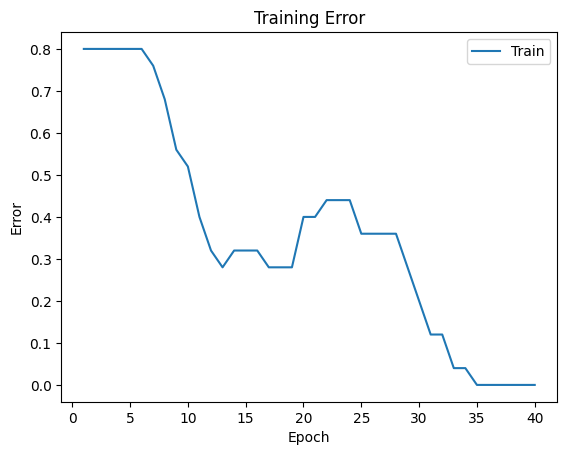

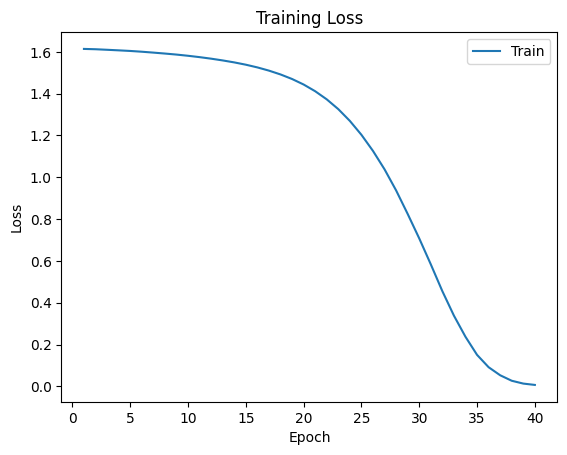

In [ ]:
net = PrimaryModel1()

train_net(net, overfit_loader, device, batch_size=25, num_epochs=40,
          results_folder=results_folder_path)

plot_training_curve(get_model_name(net.name, 25, 0.01, 40-1,
                                   results_folder_path))

Overfitting `PrimaryModel2()`:

Beginning Training...
Epoch: 1 Train err: 0.8, Train loss: 1.6124403476715088
Epoch: 2 Train err: 0.76, Train loss: 1.6107312440872192
Epoch: 3 Train err: 0.76, Train loss: 1.6078729629516602
Epoch: 4 Train err: 0.72, Train loss: 1.6040451526641846
Epoch: 5 Train err: 0.68, Train loss: 1.599647045135498
Epoch: 6 Train err: 0.68, Train loss: 1.5945274829864502
Epoch: 7 Train err: 0.64, Train loss: 1.5887199640274048
Epoch: 8 Train err: 0.64, Train loss: 1.5821905136108398
Epoch: 9 Train err: 0.6, Train loss: 1.5750218629837036
Epoch: 10 Train err: 0.68, Train loss: 1.567075490951538
Epoch: 11 Train err: 0.68, Train loss: 1.558322548866272
Epoch: 12 Train err: 0.64, Train loss: 1.5485495328903198
Epoch: 13 Train err: 0.6, Train loss: 1.5375934839248657
Epoch: 14 Train err: 0.56, Train loss: 1.525831937789917
Epoch: 15 Train err: 0.44, Train loss: 1.5123414993286133
Epoch: 16 Train err: 0.4, Train loss: 1.497222900390625
Epoch: 17 Train err: 0.4, Train loss: 1.4803084135055542
Epoch: 18 T

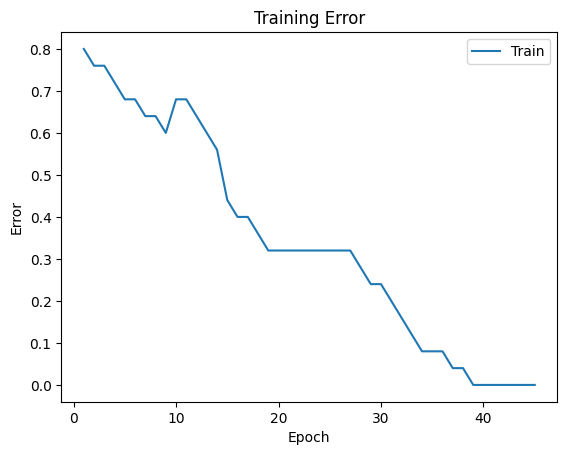

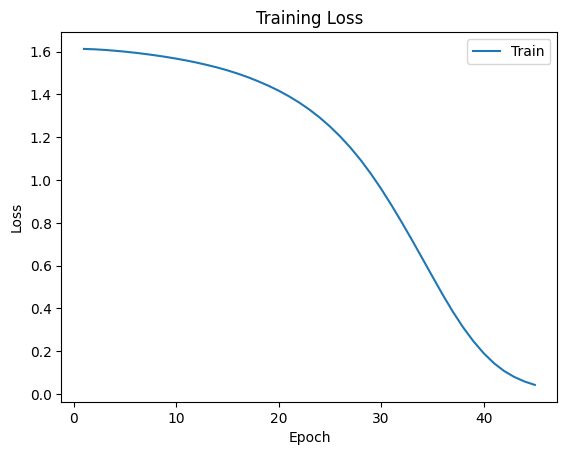

In [ ]:
net = PrimaryModel2()

train_net(net, overfit_loader, device, batch_size=25, num_epochs=45,
          results_folder=results_folder_path)

plot_training_curve(get_model_name(net.name, 25, 0.01, 45-1,
                                   results_folder_path))

Overfitting `PrimaryModel3()`:

Beginning Training...
Epoch: 1 Train err: 0.8, Train loss: 1.6111761331558228
Epoch: 2 Train err: 0.8, Train loss: 1.6106301546096802
Epoch: 3 Train err: 0.8, Train loss: 1.6096910238265991
Epoch: 4 Train err: 0.8, Train loss: 1.6084495782852173
Epoch: 5 Train err: 0.8, Train loss: 1.6070877313613892
Epoch: 6 Train err: 0.8, Train loss: 1.605690598487854
Epoch: 7 Train err: 0.8, Train loss: 1.6040867567062378
Epoch: 8 Train err: 0.8, Train loss: 1.6022709608078003
Epoch: 9 Train err: 0.8, Train loss: 1.6002999544143677
Epoch: 10 Train err: 0.8, Train loss: 1.5982427597045898
Epoch: 11 Train err: 0.8, Train loss: 1.5960686206817627
Epoch: 12 Train err: 0.76, Train loss: 1.5937577486038208
Epoch: 13 Train err: 0.76, Train loss: 1.591322422027588
Epoch: 14 Train err: 0.68, Train loss: 1.5886918306350708
Epoch: 15 Train err: 0.6, Train loss: 1.5858176946640015
Epoch: 16 Train err: 0.56, Train loss: 1.5827521085739136
Epoch: 17 Train err: 0.48, Train loss: 1.5795670747756958
Epoch: 18 Train

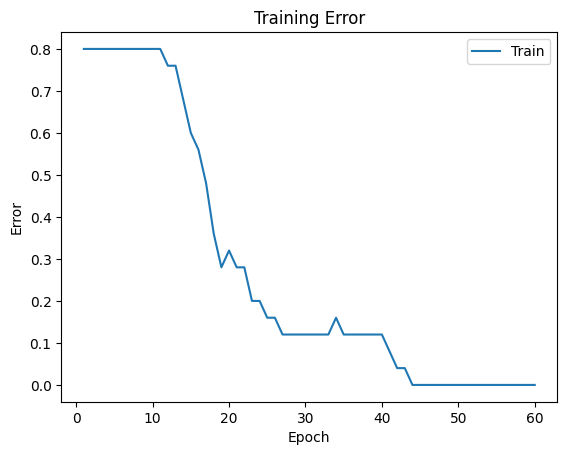

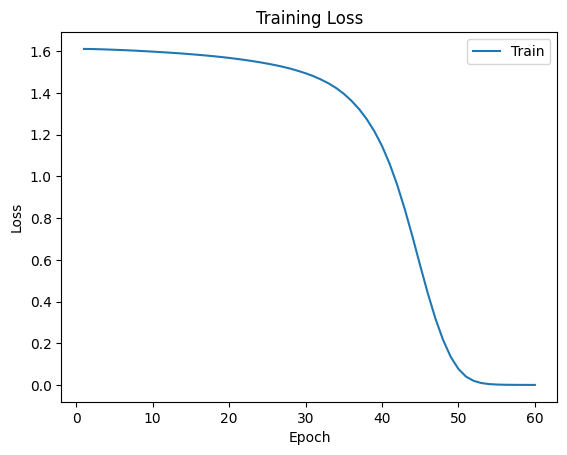

In [ ]:
net = PrimaryModel3()

train_net(net, overfit_loader, device, batch_size=25, num_epochs=60,
          results_folder=results_folder_path)

plot_training_curve(get_model_name(net.name, 25, 0.01, 60-1,
                                   results_folder_path))

Overfitting `BaselineModel()`:

Beginning Training...
Epoch: 1 Train err: 0.84, Train loss: 1.6204209327697754
Epoch: 2 Train err: 0.6, Train loss: 1.5338724851608276
Epoch: 3 Train err: 0.32, Train loss: 1.427241563796997
Epoch: 4 Train err: 0.2, Train loss: 1.2467358112335205
Epoch: 5 Train err: 0.16, Train loss: 1.02518892288208
Epoch: 6 Train err: 0.12, Train loss: 0.800130307674408
Epoch: 7 Train err: 0.12, Train loss: 0.6018569469451904
Epoch: 8 Train err: 0.12, Train loss: 0.4343246519565582
Epoch: 9 Train err: 0.04, Train loss: 0.3041302561759949
Epoch: 10 Train err: 0.0, Train loss: 0.20841072499752045
Epoch: 11 Train err: 0.0, Train loss: 0.13979022204875946
Epoch: 12 Train err: 0.0, Train loss: 0.08928067237138748
Epoch: 13 Train err: 0.0, Train loss: 0.05380097031593323
Epoch: 14 Train err: 0.0, Train loss: 0.030752409249544144
Epoch: 15 Train err: 0.0, Train loss: 0.01715458370745182
Epoch: 16 Train err: 0.0, Train loss: 0.009739215485751629
Epoch: 17 Train err: 0.0, Train loss: 0.005819524638354778
Epoc

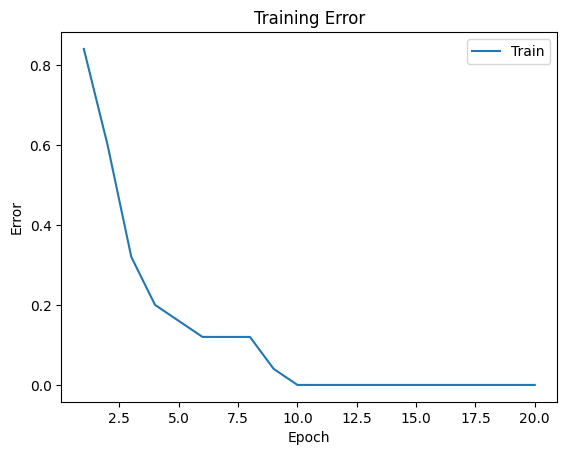

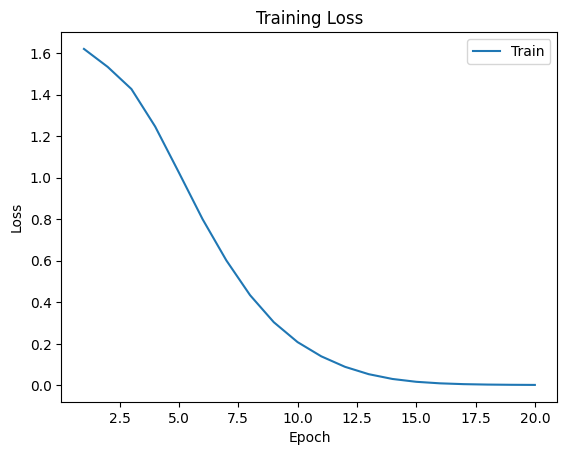

In [ ]:
baseline_net = BaselineModel()

train_net(baseline_net, overfit_loader, device, batch_size=25, num_epochs=20,
          results_folder=results_folder_path)

plot_training_curve(get_model_name(baseline_net.name, 25, 0.01, 20-1,
                                   results_folder_path))

## Training on kaggle dataset

All models are trained on the Kaggle Fruits Classification Dataset, which can be found [here](https://www.kaggle.com/datasets/utkarshsaxenadn/fruits-classification/data). I uploaded the dataset to my google drive, and used it from there for training.

Each model (all three primary models and baseline models) were tested with 3 different hyperparameter settings for 25 epochs, to optimize each model.

### Training Baseline model

The first hyperparameter setting is:

- Batch Size = 256
- Learning Rate = 0.01

Retrieving dataset from /content/gdrive/MyDrive/Colab Notebooks/APS360/Project/Data/train...
Done retrieving dataset.
Retrieving dataset from /content/gdrive/MyDrive/Colab Notebooks/APS360/Project/Data/valid...
Done retrieving dataset.
Beginning Training...
Epoch: 1 Train err: 0.6201030927835052, Train loss: 1.4220884724667198 | Validation err: 0.625, Validation loss: 1.3437724113464355
Epoch: 2 Train err: 0.5135051546391752, Train loss: 1.2232284357673244 | Validation err: 0.565, Validation loss: 1.2552807331085205
Epoch: 3 Train err: 0.4622680412371134, Train loss: 1.1345626241282414 | Validation err: 0.55, Validation loss: 1.2794530391693115
Epoch: 4 Train err: 0.42381443298969074, Train loss: 1.0653922871539467 | Validation err: 0.56, Validation loss: 1.2568243741989136
Epoch: 5 Train err: 0.411340206185567, Train loss: 1.026952718433581 | Validation err: 0.54, Validation loss: 1.2788615226745605
Epoch: 6 Train err: 0.3658762886597938, Train loss: 0.9400889199031027 | Validation er

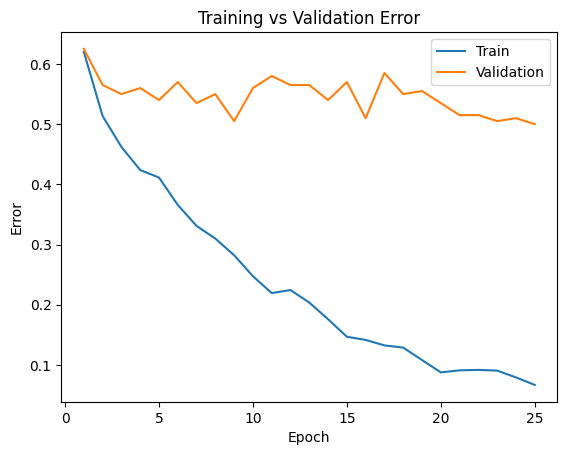

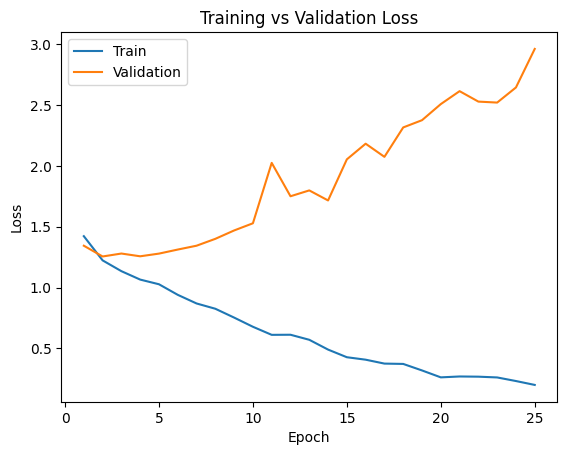

In [ ]:
training_loader = get_data_loader(("/content/gdrive/MyDrive/Colab Notebooks"
                                    "/APS360/Project/Data/train"), 256)
validation_loader = get_data_loader(("/content/gdrive/MyDrive/Colab Notebooks"
                                    "/APS360/Project/Data/valid"), 256)

baseline_net = BaselineModel()

train_net(baseline_net, training_loader, device, validation_loader, 256, 0.01, 25,
          results_folder_path)

plot_training_vs_validation_curve(get_model_name(baseline_net.name, 256, 0.01,
                                                 25-1, results_folder_path))

The second hyperparameter setting is:

- Batch Size = 324
- Learning Rate = 0.015

Retrieving dataset from /content/gdrive/MyDrive/Colab Notebooks/APS360/Project/Data/train...
Done retrieving dataset.
Retrieving dataset from /content/gdrive/MyDrive/Colab Notebooks/APS360/Project/Data/valid...
Done retrieving dataset.
Beginning Training...
Epoch: 1 Train err: 0.6234020618556702, Train loss: 1.4260641058286032 | Validation err: 0.615, Validation loss: 1.327551245689392
Epoch: 2 Train err: 0.5074226804123712, Train loss: 1.2133038640022278 | Validation err: 0.55, Validation loss: 1.2493189573287964
Epoch: 3 Train err: 0.4663917525773196, Train loss: 1.131483268737793 | Validation err: 0.56, Validation loss: 1.2471611499786377
Epoch: 4 Train err: 0.424639175257732, Train loss: 1.0577178835868835 | Validation err: 0.54, Validation loss: 1.2460097074508667
Epoch: 5 Train err: 0.40154639175257734, Train loss: 1.0108552197615306 | Validation err: 0.555, Validation loss: 1.278918743133545
Epoch: 6 Train err: 0.3595876288659794, Train loss: 0.9221757431825002 | Validation err:

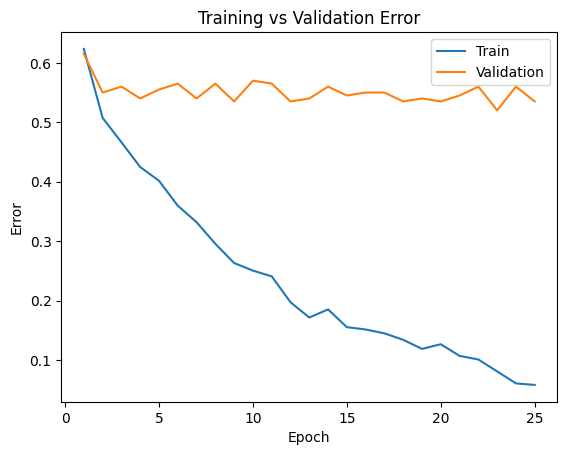

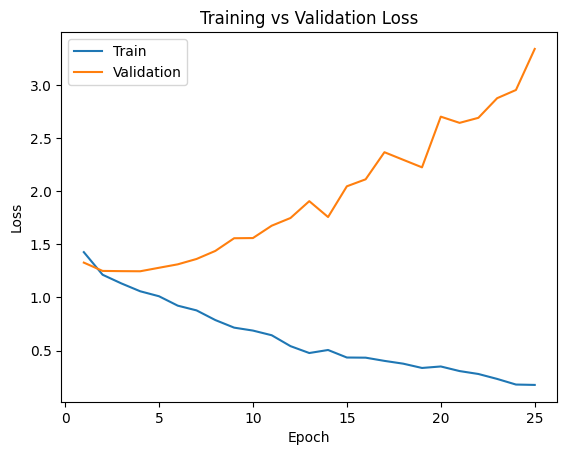

In [ ]:
training_loader = get_data_loader(("/content/gdrive/MyDrive/Colab Notebooks"
                                    "/APS360/Project/Data/train"), 324)
validation_loader = get_data_loader(("/content/gdrive/MyDrive/Colab Notebooks"
                                    "/APS360/Project/Data/valid"), 324)

baseline_net = BaselineModel()

train_net(baseline_net, training_loader, device, validation_loader, 324, 0.015, 25,
          results_folder_path)

plot_training_vs_validation_curve(get_model_name(baseline_net.name, 324, 0.015,
                                                 25-1, results_folder_path))

The third hyperparameter setting is:

- Batch Size = 400
- Learning Rate = 0.0138

Retrieving dataset from /content/gdrive/MyDrive/Colab Notebooks/APS360/Project/Data/train...
Done retrieving dataset.
Retrieving dataset from /content/gdrive/MyDrive/Colab Notebooks/APS360/Project/Data/valid...
Done retrieving dataset.
Beginning Training...
Epoch: 1 Train err: 0.6369072164948454, Train loss: 1.4485188817977905 | Validation err: 0.585, Validation loss: 1.3332980871200562
Epoch: 2 Train err: 0.5136082474226804, Train loss: 1.2310542488098144 | Validation err: 0.535, Validation loss: 1.2595924139022827
Epoch: 3 Train err: 0.465979381443299, Train loss: 1.1486655235290528 | Validation err: 0.565, Validation loss: 1.3141118288040161
Epoch: 4 Train err: 0.44237113402061856, Train loss: 1.0850163173675538 | Validation err: 0.555, Validation loss: 1.2763172388076782
Epoch: 5 Train err: 0.4194845360824742, Train loss: 1.0539270853996277 | Validation err: 0.575, Validation loss: 1.309208631515503
Epoch: 6 Train err: 0.3957731958762887, Train loss: 0.998992133140564 | Validation 

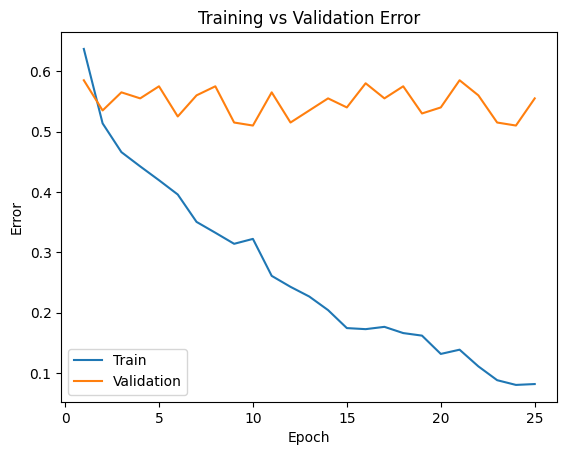

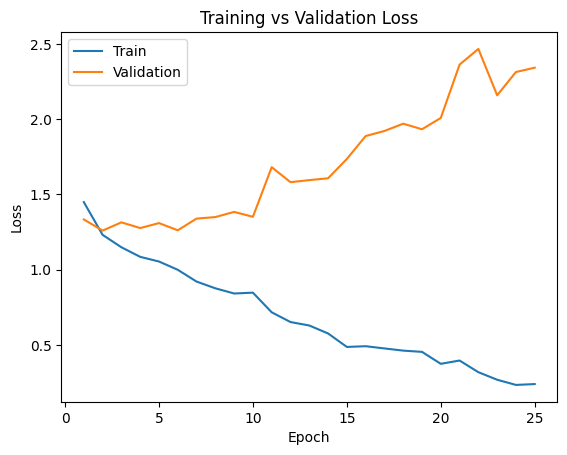

In [ ]:
training_loader = get_data_loader(("/content/gdrive/MyDrive/Colab Notebooks"
                                    "/APS360/Project/Data/train"), 400)
validation_loader = get_data_loader(("/content/gdrive/MyDrive/Colab Notebooks"
                                    "/APS360/Project/Data/valid"), 400)

baseline_net = BaselineModel()

train_net(baseline_net, training_loader, device, validation_loader, 400, 0.0138, 25,
          results_folder_path)

plot_training_vs_validation_curve(get_model_name(baseline_net.name, 400, 0.0138,
                                                 25-1, results_folder_path))

### Training PrimaryModel1

The first hyperparameter setting is:

- Batch Size = 256
- Learning Rate = 0.01

Retrieving dataset from /content/gdrive/MyDrive/Colab Notebooks/APS360/Project/Data/train...
Done retrieving dataset.
Retrieving dataset from /content/gdrive/MyDrive/Colab Notebooks/APS360/Project/Data/valid...
Done retrieving dataset.
Beginning Training...
Epoch: 1 Train err: 0.7734020618556701, Train loss: 1.6047333698523671 | Validation err: 0.62, Validation loss: 1.5899564027786255
Epoch: 2 Train err: 0.6, Train loss: 1.481267301659835 | Validation err: 0.57, Validation loss: 1.3909063339233398
Epoch: 3 Train err: 0.5279381443298969, Train loss: 1.228435804969386 | Validation err: 0.5, Validation loss: 1.2057548761367798
Epoch: 4 Train err: 0.4761855670103093, Train loss: 1.127126649806374 | Validation err: 0.46, Validation loss: 1.1374809741973877
Epoch: 5 Train err: 0.44082474226804125, Train loss: 1.0639035074334395 | Validation err: 0.455, Validation loss: 1.1131279468536377
Epoch: 6 Train err: 0.40845360824742266, Train loss: 1.0065074249317771 | Validation err: 0.435, Validat

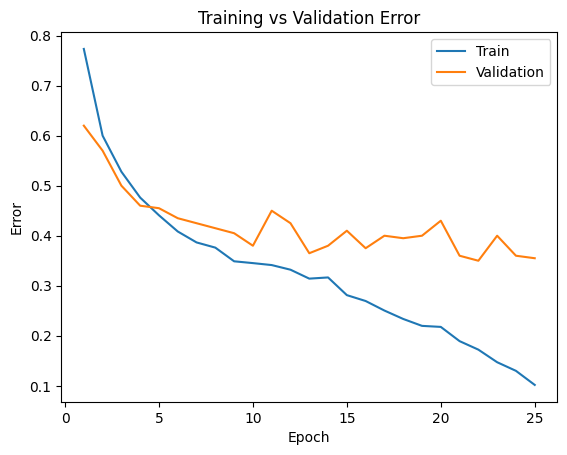

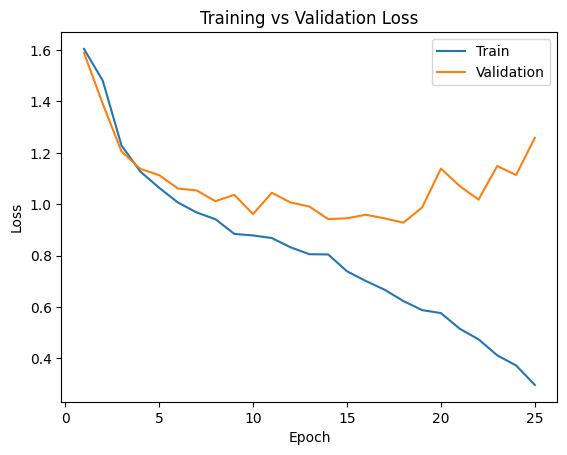

In [ ]:
training_loader = get_data_loader(("/content/gdrive/MyDrive/Colab Notebooks"
                                    "/APS360/Project/Data/train"), 256)
validation_loader = get_data_loader(("/content/gdrive/MyDrive/Colab Notebooks"
                                    "/APS360/Project/Data/valid"), 256)

net = PrimaryModel1()

train_net(net, training_loader, device, validation_loader, 256, 0.01, 25,
          results_folder_path)


plot_training_vs_validation_curve(get_model_name(net.name, 256, 0.01,
                                                 25-1, results_folder_path))

The second hyperparameter setting is:

- Batch Size = 324
- Learning Rate = 0.015

Retrieving dataset from /content/gdrive/MyDrive/Colab Notebooks/APS360/Project/Data/train...
Done retrieving dataset.
Retrieving dataset from /content/gdrive/MyDrive/Colab Notebooks/APS360/Project/Data/valid...
Done retrieving dataset.
Beginning Training...
Epoch: 1 Train err: 0.7141237113402061, Train loss: 1.5719340324401856 | Validation err: 0.65, Validation loss: 1.437691330909729
Epoch: 2 Train err: 0.5928865979381444, Train loss: 1.3410088658332824 | Validation err: 0.57, Validation loss: 1.278428554534912
Epoch: 3 Train err: 0.517319587628866, Train loss: 1.209929625193278 | Validation err: 0.5, Validation loss: 1.2177067995071411
Epoch: 4 Train err: 0.47195876288659794, Train loss: 1.1259514172871907 | Validation err: 0.535, Validation loss: 1.2169405221939087
Epoch: 5 Train err: 0.4402061855670103, Train loss: 1.0686410427093507 | Validation err: 0.455, Validation loss: 1.128262996673584
Epoch: 6 Train err: 0.4143298969072165, Train loss: 1.0089025219281516 | Validation err: 0

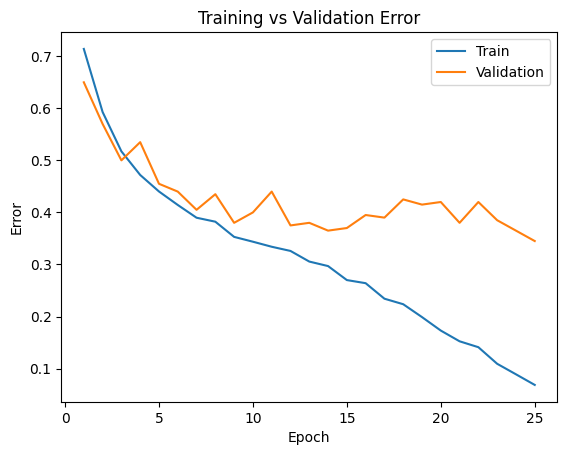

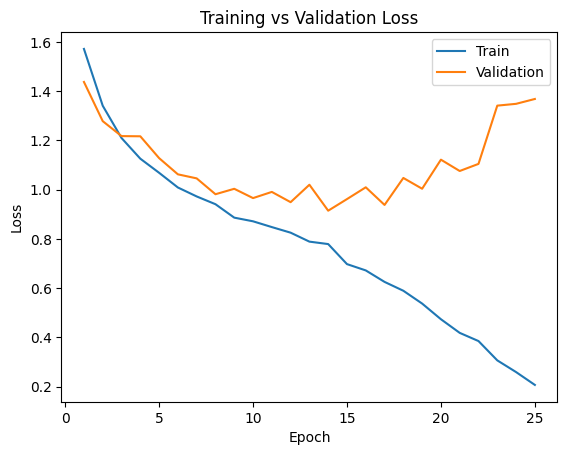

In [ ]:
training_loader = get_data_loader(("/content/gdrive/MyDrive/Colab Notebooks"
                                    "/APS360/Project/Data/train"), 324)
validation_loader = get_data_loader(("/content/gdrive/MyDrive/Colab Notebooks"
                                    "/APS360/Project/Data/valid"), 324)

net = PrimaryModel1()

train_net(net, training_loader, device, validation_loader, 324, 0.015, 25,
          results_folder_path)

plot_training_vs_validation_curve(get_model_name(net.name, 324, 0.015,
                                                 25-1, results_folder_path))

The second hyperparameter setting is:

- Batch Size = 400
- Learning Rate = 0.0176

Retrieving dataset from /content/gdrive/MyDrive/Colab Notebooks/APS360/Project/Data/train...
Done retrieving dataset.
Retrieving dataset from /content/gdrive/MyDrive/Colab Notebooks/APS360/Project/Data/valid...
Done retrieving dataset.
Beginning Training...
Epoch: 1 Train err: 0.7297938144329897, Train loss: 1.5833061933517456 | Validation err: 0.62, Validation loss: 1.4807661771774292
Epoch: 2 Train err: 0.5990721649484536, Train loss: 1.3595209455490112 | Validation err: 0.535, Validation loss: 1.285793662071228
Epoch: 3 Train err: 0.5287628865979381, Train loss: 1.2248389768600463 | Validation err: 0.555, Validation loss: 1.2615971565246582
Epoch: 4 Train err: 0.491340206185567, Train loss: 1.1511960101127625 | Validation err: 0.54, Validation loss: 1.2134937047958374
Epoch: 5 Train err: 0.47876288659793814, Train loss: 1.1198156118392943 | Validation err: 0.51, Validation loss: 1.1725996732711792
Epoch: 6 Train err: 0.43742268041237115, Train loss: 1.047927098274231 | Validation er

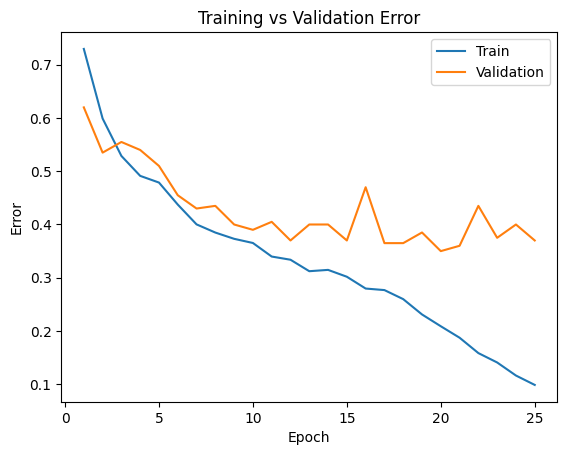

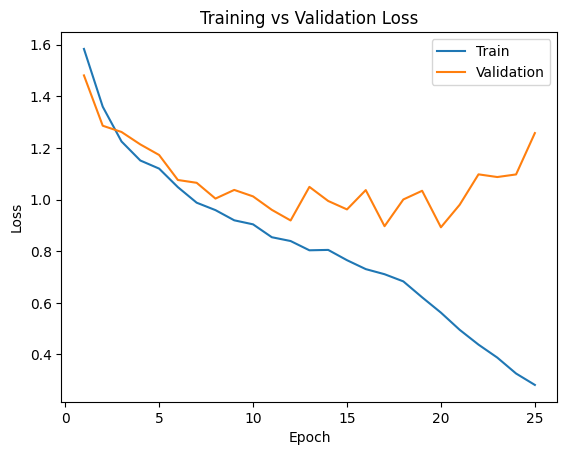

In [ ]:
training_loader = get_data_loader(("/content/gdrive/MyDrive/Colab Notebooks"
                                    "/APS360/Project/Data/train"), 400)
validation_loader = get_data_loader(("/content/gdrive/MyDrive/Colab Notebooks"
                                    "/APS360/Project/Data/valid"), 400)

net = PrimaryModel1()

train_net(net, training_loader, device, validation_loader, 400, 0.0176, 25,
          results_folder_path)

plot_training_vs_validation_curve(get_model_name(net.name, 400, 0.0176,
                                                 25-1, results_folder_path))

### Training PrimaryModel2

The first hyperparameter setting is:

- Batch Size = 256
- Learning Rate = 0.01

Retrieving dataset from /content/gdrive/MyDrive/Colab Notebooks/APS360/Project/Data/train...
Done retrieving dataset.
Retrieving dataset from /content/gdrive/MyDrive/Colab Notebooks/APS360/Project/Data/valid...
Done retrieving dataset.
Beginning Training...
Epoch: 1 Train err: 0.6934020618556701, Train loss: 1.553032818593477 | Validation err: 0.69, Validation loss: 1.4635049104690552
Epoch: 2 Train err: 0.5704123711340207, Train loss: 1.3144512929414447 | Validation err: 0.605, Validation loss: 1.3101764917373657
Epoch: 3 Train err: 0.5244329896907216, Train loss: 1.2130019507910077 | Validation err: 0.55, Validation loss: 1.2570306062698364
Epoch: 4 Train err: 0.49030927835051547, Train loss: 1.1571441731954877 | Validation err: 0.53, Validation loss: 1.1974750757217407
Epoch: 5 Train err: 0.48, Train loss: 1.1273829278193022 | Validation err: 0.49, Validation loss: 1.1800612211227417
Epoch: 6 Train err: 0.44628865979381444, Train loss: 1.0639321568765139 | Validation err: 0.475, Val

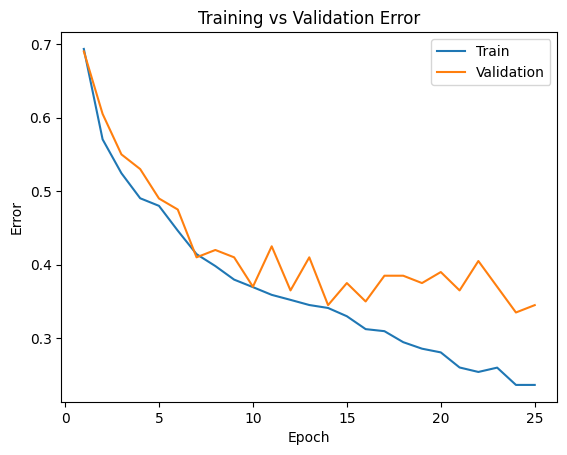

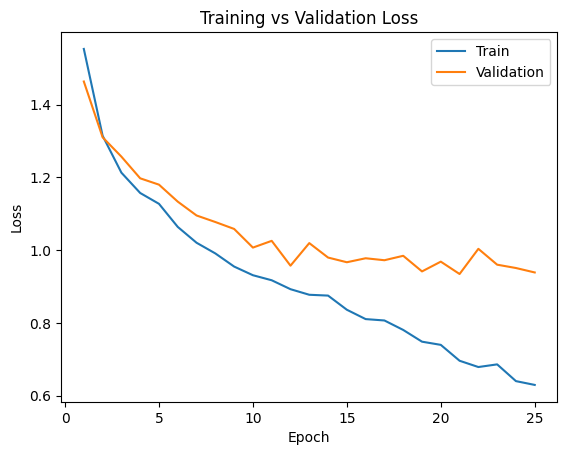

In [ ]:
training_loader = get_data_loader(("/content/gdrive/MyDrive/Colab Notebooks"
                                    "/APS360/Project/Data/train"), 256)
validation_loader = get_data_loader(("/content/gdrive/MyDrive/Colab Notebooks"
                                    "/APS360/Project/Data/valid"), 256)

net = PrimaryModel2()

train_net(net, training_loader, device, validation_loader, 256, 0.01, 25,
          results_folder_path)

plot_training_vs_validation_curve(get_model_name(net.name, 256, 0.01,
                                                 25-1, results_folder_path))

The second hyperparameter setting is:

- Batch Size = 324
- Learning Rate = 0.015

Retrieving dataset from /content/gdrive/MyDrive/Colab Notebooks/APS360/Project/Data/train...
Done retrieving dataset.
Retrieving dataset from /content/gdrive/MyDrive/Colab Notebooks/APS360/Project/Data/valid...
Done retrieving dataset.
Beginning Training...
Epoch: 1 Train err: 0.6949484536082474, Train loss: 1.5506518642107645 | Validation err: 0.685, Validation loss: 1.4588905572891235
Epoch: 2 Train err: 0.5655670103092784, Train loss: 1.3061235626538594 | Validation err: 0.59, Validation loss: 1.308984637260437
Epoch: 3 Train err: 0.5183505154639175, Train loss: 1.206579820315043 | Validation err: 0.57, Validation loss: 1.2484955787658691
Epoch: 4 Train err: 0.48690721649484536, Train loss: 1.1454943021138508 | Validation err: 0.52, Validation loss: 1.1801868677139282
Epoch: 5 Train err: 0.468659793814433, Train loss: 1.1091890692710877 | Validation err: 0.505, Validation loss: 1.17898428440094
Epoch: 6 Train err: 0.43422680412371134, Train loss: 1.0461084643999736 | Validation err:

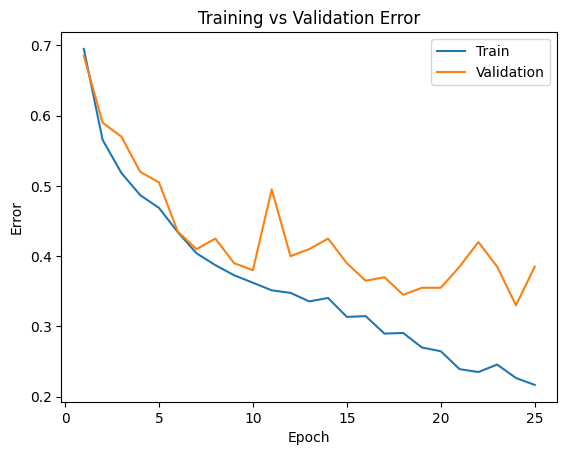

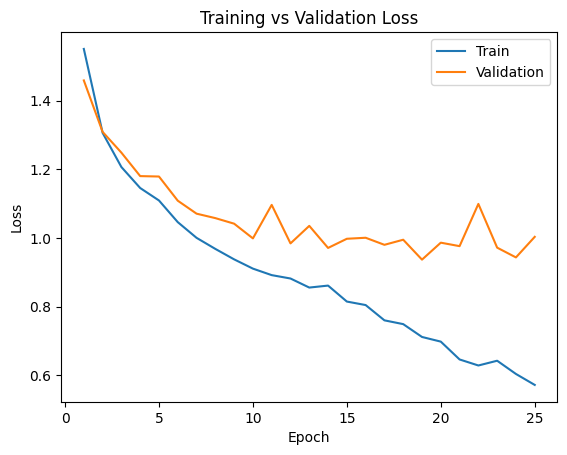

In [ ]:
training_loader = get_data_loader(("/content/gdrive/MyDrive/Colab Notebooks"
                                    "/APS360/Project/Data/train"), 324)
validation_loader = get_data_loader(("/content/gdrive/MyDrive/Colab Notebooks"
                                    "/APS360/Project/Data/valid"), 324)

net = PrimaryModel2()

train_net(net, training_loader, device, validation_loader, 324, 0.015, 25,
          results_folder_path)

plot_training_vs_validation_curve(get_model_name(net.name, 324, 0.015,
                                                 25-1, results_folder_path))

The third hyperparameter setting is:

- Batch Size = 384
- Learning Rate = 0.02

Retrieving dataset from /content/gdrive/MyDrive/Colab Notebooks/APS360/Project/Data/train...
Done retrieving dataset.
Retrieving dataset from /content/gdrive/MyDrive/Colab Notebooks/APS360/Project/Data/valid...
Done retrieving dataset.
Beginning Training...
Epoch: 1 Train err: 0.6982474226804124, Train loss: 1.5470761565061717 | Validation err: 0.66, Validation loss: 1.4470988512039185
Epoch: 2 Train err: 0.5674226804123711, Train loss: 1.2974333396324744 | Validation err: 0.58, Validation loss: 1.3021185398101807
Epoch: 3 Train err: 0.5185567010309279, Train loss: 1.2047691070116484 | Validation err: 0.535, Validation loss: 1.2360306978225708
Epoch: 4 Train err: 0.48701030927835054, Train loss: 1.1330872865823598 | Validation err: 0.54, Validation loss: 1.2074581384658813
Epoch: 5 Train err: 0.4660824742268041, Train loss: 1.106900352698106 | Validation err: 0.455, Validation loss: 1.1254703998565674
Epoch: 6 Train err: 0.42597938144329894, Train loss: 1.0343200335135827 | Validation 

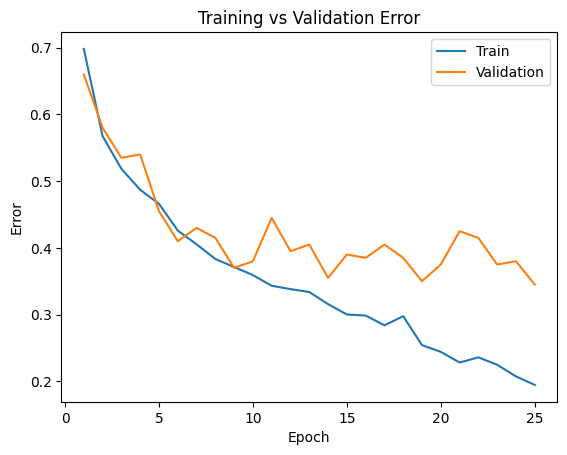

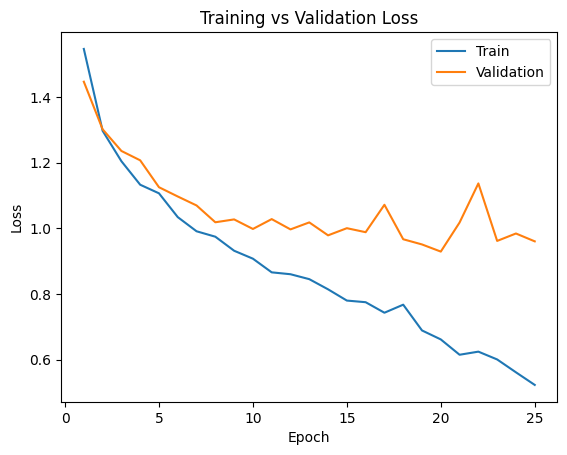

In [ ]:
training_loader = get_data_loader(("/content/gdrive/MyDrive/Colab Notebooks"
                                    "/APS360/Project/Data/train"), 384)
validation_loader = get_data_loader(("/content/gdrive/MyDrive/Colab Notebooks"
                                    "/APS360/Project/Data/valid"), 384)

net = PrimaryModel2()

train_net(net, training_loader, device, validation_loader, 384, 0.02, 25,
          results_folder_path)

plot_training_vs_validation_curve(get_model_name(net.name, 384, 0.02,
                                                 25-1, results_folder_path))

### Training PrimaryModel3

The first hyperparameter setting is:

- Batch Size = 256
- Learning Rate = 0.01

Retrieving dataset from /content/gdrive/MyDrive/Colab Notebooks/APS360/Project/Data/train...
Done retrieving dataset.
Retrieving dataset from /content/gdrive/MyDrive/Colab Notebooks/APS360/Project/Data/valid...
Done retrieving dataset.
Beginning Training...
Epoch: 1 Train err: 0.7885567010309278, Train loss: 1.613480081683711 | Validation err: 0.715, Validation loss: 1.6034598350524902
Epoch: 2 Train err: 0.6834020618556701, Train loss: 1.5901089749838178 | Validation err: 0.58, Validation loss: 1.5487420558929443
Epoch: 3 Train err: 0.6108247422680413, Train loss: 1.415875792503357 | Validation err: 0.565, Validation loss: 1.3483853340148926
Epoch: 4 Train err: 0.5317525773195876, Train loss: 1.233289201008646 | Validation err: 0.52, Validation loss: 1.2185349464416504
Epoch: 5 Train err: 0.49907216494845363, Train loss: 1.1656590857003863 | Validation err: 0.485, Validation loss: 1.1706314086914062
Epoch: 6 Train err: 0.4605154639175258, Train loss: 1.0907715559005737 | Validation er

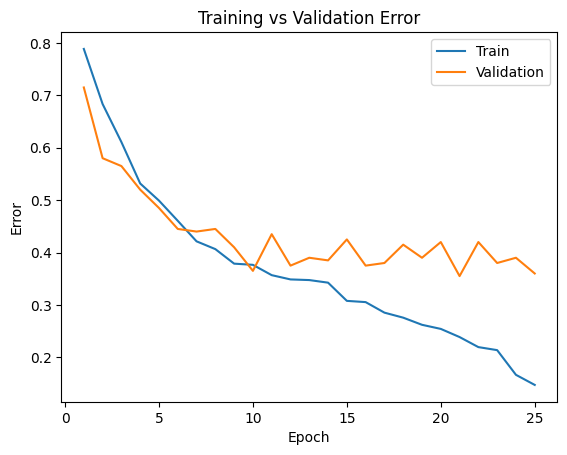

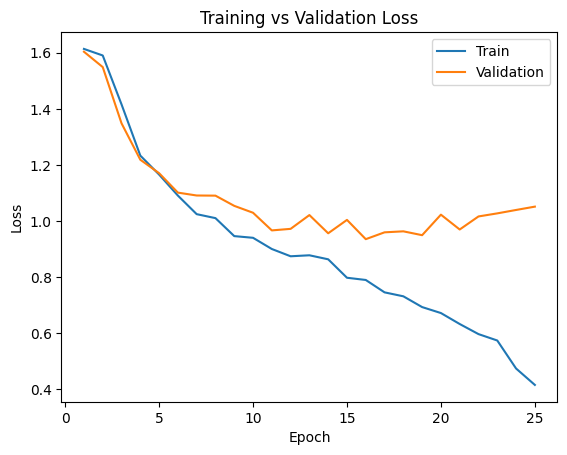

In [ ]:
training_loader = get_data_loader(("/content/gdrive/MyDrive/Colab Notebooks"
                                    "/APS360/Project/Data/train"), 256)
validation_loader = get_data_loader(("/content/gdrive/MyDrive/Colab Notebooks"
                                    "/APS360/Project/Data/valid"), 256)

net = PrimaryModel3()

train_net(net, training_loader, device, validation_loader, 256, 0.01, 25,
          results_folder_path)

plot_training_vs_validation_curve(get_model_name(net.name, 256, 0.01,
                                                 25-1, results_folder_path))

The second hyperparameter setting is:

- Batch Size = 324
- Learning Rate = 0.015

Retrieving dataset from /content/gdrive/MyDrive/Colab Notebooks/APS360/Project/Data/train...
Done retrieving dataset.
Retrieving dataset from /content/gdrive/MyDrive/Colab Notebooks/APS360/Project/Data/valid...
Done retrieving dataset.
Beginning Training...
Epoch: 1 Train err: 0.7771134020618556, Train loss: 1.6136696577072143 | Validation err: 0.67, Validation loss: 1.6033896207809448
Epoch: 2 Train err: 0.6725773195876289, Train loss: 1.5914275606473287 | Validation err: 0.6, Validation loss: 1.550197958946228
Epoch: 3 Train err: 0.6116494845360825, Train loss: 1.4210381746292113 | Validation err: 0.565, Validation loss: 1.328275442123413
Epoch: 4 Train err: 0.5279381443298969, Train loss: 1.230023709932963 | Validation err: 0.53, Validation loss: 1.2250245809555054
Epoch: 5 Train err: 0.4943298969072165, Train loss: 1.1601183454195658 | Validation err: 0.46, Validation loss: 1.163346290588379
Epoch: 6 Train err: 0.4520618556701031, Train loss: 1.0764511128266652 | Validation err: 0.

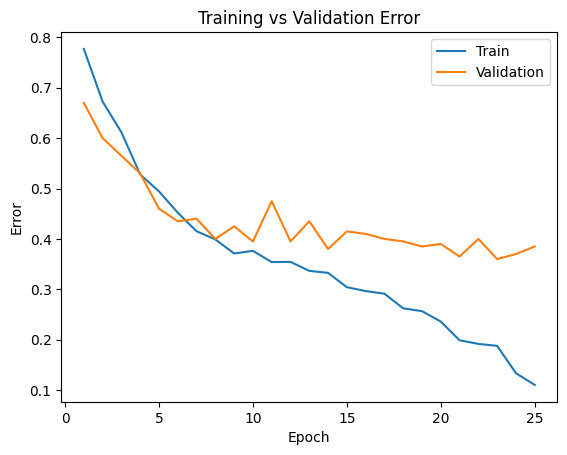

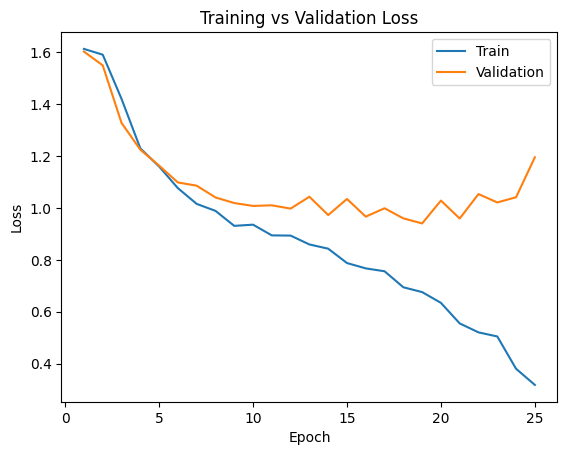

In [ ]:
training_loader = get_data_loader(("/content/gdrive/MyDrive/Colab Notebooks"
                                    "/APS360/Project/Data/train"), 324)
validation_loader = get_data_loader(("/content/gdrive/MyDrive/Colab Notebooks"
                                    "/APS360/Project/Data/valid"), 324)

net = PrimaryModel3()

train_net(net, training_loader, device, validation_loader, 324, 0.015, 25,
          results_folder_path)

plot_training_vs_validation_curve(get_model_name(net.name, 324, 0.015,
                                                 25-1, results_folder_path))

The third hyperparameter setting is:

- Batch Size = 396
- Learning Rate = 0.0185

Retrieving dataset from /content/gdrive/MyDrive/Colab Notebooks/APS360/Project/Data/train...
Done retrieving dataset.
Retrieving dataset from /content/gdrive/MyDrive/Colab Notebooks/APS360/Project/Data/valid...
Done retrieving dataset.
Beginning Training...
Epoch: 1 Train err: 0.7802061855670103, Train loss: 1.6100909280776978 | Validation err: 0.69, Validation loss: 1.5915493965148926
Epoch: 2 Train err: 0.6749484536082474, Train loss: 1.5007551431655883 | Validation err: 0.61, Validation loss: 1.365342617034912
Epoch: 3 Train err: 0.5767010309278351, Train loss: 1.3171492052078246 | Validation err: 0.57, Validation loss: 1.303463101387024
Epoch: 4 Train err: 0.5410309278350516, Train loss: 1.24104163646698 | Validation err: 0.56, Validation loss: 1.2655938863754272
Epoch: 5 Train err: 0.5210309278350516, Train loss: 1.1897398853302001 | Validation err: 0.495, Validation loss: 1.1945546865463257
Epoch: 6 Train err: 0.48721649484536084, Train loss: 1.1307318496704102 | Validation err: 

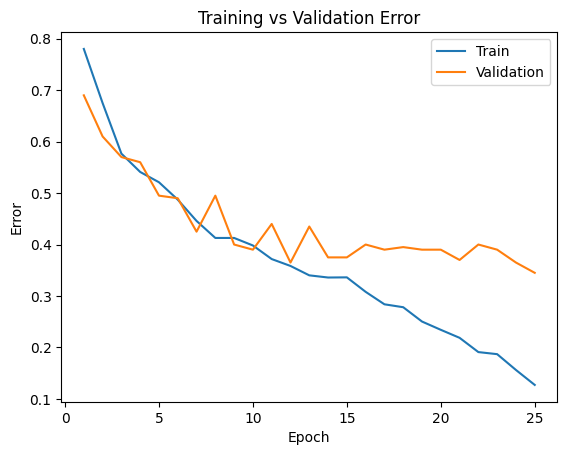

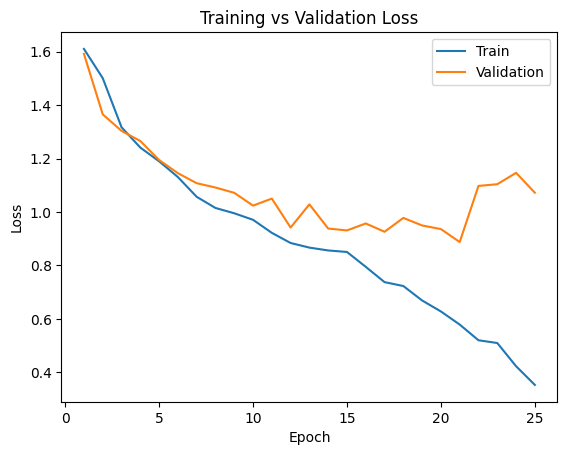

In [ ]:
training_loader = get_data_loader(("/content/gdrive/MyDrive/Colab Notebooks"
                                    "/APS360/Project/Data/train"), 396)
validation_loader = get_data_loader(("/content/gdrive/MyDrive/Colab Notebooks"
                                    "/APS360/Project/Data/valid"), 396)

net = PrimaryModel3()

train_net(net, training_loader, device, validation_loader, 396, 0.0185, 25,
          results_folder_path)

plot_training_vs_validation_curve(get_model_name(net.name, 396, 0.0185,
                                                 25-1, results_folder_path))

# Testing & Results

## Testing without manually collected data

First we can test just on the Kaggle testing dataset, without considering the new manually collected images.

### Baseline model

The optimal settings for the baseline model were with:

- Batch size: 400
- Learning Rate: 0.0138
- Epoch: 10

In [ ]:
testing_loader = get_data_loader(("/content/gdrive/MyDrive/Colab Notebooks"
                                    "/APS360/Project/Data/test"), 1)

baseline_net = BaselineModel()
baseline_net.load_state_dict(torch.load(get_model_name(baseline_net.name,
                                                       400,
                                                       0.0138,
                                                       10-1,
                                                       results_folder_path)))

test_error, test_loss = evaluate(baseline_net, testing_loader,
                                 nn.CrossEntropyLoss(), device)

print("The testing accuracy for the baseline model is", 1-test_error)

Retrieving dataset from /content/gdrive/MyDrive/Colab Notebooks/APS360/Project/Data/test...
Done retrieving dataset.
The testing accuracy for the baseline model is 0.43999999999999995


### Primary model

The best model was `PrimaryModel1()`

The optimal primary model was `PrimaryModel1()` with the following settings:

- Batch size: 400
- Learning Rate: 0.0176
- Epoch: 20

In [ ]:
testing_loader = get_data_loader(("/content/gdrive/MyDrive/Colab Notebooks"
                                    "/APS360/Project/Data/test"), 1)

net = PrimaryModel1()
net.load_state_dict(torch.load(get_model_name(net.name,
                                                400,
                                                0.0176,
                                                20-1,
                                                results_folder_path)))

test_error, test_loss = evaluate(net, testing_loader,
                                 nn.CrossEntropyLoss(), device)

print("The testing accuracy for the primary model is", 1-test_error)

Retrieving dataset from /content/gdrive/MyDrive/Colab Notebooks/APS360/Project/Data/test...
Done retrieving dataset.
The testing accuracy for the primary model is 0.63


## Testing with manually collected data

### Baseline model

### Primary model